# 10x RNA-seq gene expression data (part 1)

This is a modified notebook from the available documents on Allen Brain Atlas github. Each dataset is divided into 24 expression matrices whee cells are grouped by 10X chemistry (10Xv2, 10Xv3, and 10XMulti) and the broad anatomical region from where the cells were dissected.

This notebook will provide an overview of the data, file organization, and how to combine data and metadata.

You need to be connected to the internet to run this notebook and that you have downloaded the necessary data from the getting started notebook.

***Most customized changes will happen under the "Gene Expression matrices" header***

In [1]:
#Make sure all of these AND 'aws-shell' and 'aws' are installed.
#if on Autry Desktop, use conda activate seq-aws

import os
import pandas as pd
import numpy as np
import anndata
import time
import matplotlib.pyplot as plt
import json
import requests

The prerequisite for running this notebook is that the data have been downloaded to local directory maintaining the organization from the manifest.json. **Change the download_base variable to where you have downloaded the data in your system.**

***MAKE CHANGES ##***

In [2]:
version = '20231215'

#only change this line.
download_base = r"C:\Users\sedwi\Desktop\SingleCell_AllenAtlas"  ##
#Add the location you want to download your files

use_local_cache = False
manifest_path = 'releases/%s/manifest.json' % version

if not use_local_cache :
    url = 'https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/' + manifest_path
    manifest = json.loads(requests.get(url).text)
else :
    file = os.path.join(download_base,manifest_path)
    with open(file,'rb') as f:
        manifest = json.load(f)
    
metadata = manifest['file_listing']['WMB-10X']['metadata']

In [3]:
view_directory = os.path.join( download_base, 
                               manifest['directory_listing']['WMB-10X']['directories']['metadata']['relative_path'], 
                              'views')
## not necessary, but *can* change this line to True or False
cache_views = True
if cache_views :
    os.makedirs( view_directory, exist_ok=True )

## Data overview
### Cell metadata

Essential cell metadata is stored as a dataframe. Each row represents one cell indexed by a *cell label*. The *cell label* is the concatenation of barcode and name of the sample. In this context, the sample is the *barcoded cell sample* that represents a single load into one port of the 10x Chromium. Note that cell barcodes are only unique within a single *barcoded cell sample* and that the same barcode can be reused. The *barcoded cell sample* label or name is unique in the database.

Each cell is associated with a *library label*, *library method*, *donor label*, *donor genotype*, *donor sex*, dissection *region of interest acronym", the corresponding coarse *anatomical division label* and the *matrix_prefix* identifying which data package this cell is part of.

Further, each cell is associated with a *cluster alias* representing which cluster this cell is a member of and (x,y) coordinates of the all cells UMAP in Figure 1 of the manuscript.

We are going to combine the cell metadata with the taxonomy metadata.

#### Example cell metadata Dataframe

In [4]:
rpath = metadata['cell_metadata']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cell = pd.read_csv(file, dtype={'cell_label':str})
cell.set_index('cell_label',inplace=True)
print("Number of cells = ", len(cell))
cell.head(5)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\sedwi\\Desktop\\SingleCell_AllenAtlas\\metadata/WMB-10X/20231215/cell_metadata.csv'

We can use panadas groupby function to see how many unique items are associated for each field and list them out if the number of items is small.

These columns can be used to index genes in the heatmap plots. Refer to the output below to help determine the information you'd like to view.

In [25]:
def print_column_info(df) :
    
    for c in df.columns :
        grouped = df[[c]].groupby(c).count()
        members = ''
        if len(grouped) < 30 :
            members = str(list(grouped.index))
        print("Number of unique %s = %d %s" % (c,len(grouped),members))
print_column_info(cell)       

Number of unique cell_barcode = 2375490 
Number of unique barcoded_cell_sample_label = 819 
Number of unique library_label = 819 
Number of unique feature_matrix_label = 24 ['WMB-10XMulti', 'WMB-10Xv2-CTXsp', 'WMB-10Xv2-HPF', 'WMB-10Xv2-HY', 'WMB-10Xv2-Isocortex-1', 'WMB-10Xv2-Isocortex-2', 'WMB-10Xv2-Isocortex-3', 'WMB-10Xv2-Isocortex-4', 'WMB-10Xv2-MB', 'WMB-10Xv2-OLF', 'WMB-10Xv2-TH', 'WMB-10Xv3-CB', 'WMB-10Xv3-CTXsp', 'WMB-10Xv3-HPF', 'WMB-10Xv3-HY', 'WMB-10Xv3-Isocortex-1', 'WMB-10Xv3-Isocortex-2', 'WMB-10Xv3-MB', 'WMB-10Xv3-MY', 'WMB-10Xv3-OLF', 'WMB-10Xv3-P', 'WMB-10Xv3-PAL', 'WMB-10Xv3-STR', 'WMB-10Xv3-TH']
Number of unique entity = 1 ['cell']
Number of unique brain_section_label = 0 []
Number of unique library_method = 3 ['10Xv2', '10Xv3', '10xRSeq_Mult']
Number of unique region_of_interest_acronym = 29 ['ACA', 'AI', 'AUD', 'AUD-TEa-PERI-ECT', 'CB', 'CTXsp', 'ENT', 'HIP', 'HY', 'LSX', 'MB', 'MO-FRP', 'MOp', 'MY', 'OLF', 'P', 'PAL', 'PL-ILA-ORB', 'RHP', 'RSP', 'SS-GU-VISC', 'SS

##### Example of indexing by the columns

In [26]:
# cell.groupby('dataset_label')[['x']].count()

cell.groupby('region_of_interest_acronym')[['donor_sex']].count()

,donor_sex
region_of_interest_acronym,
ACA,102794
AI,99046
AUD,70564
AUD-TEa-PERI-ECT,26920
CB,182004
CTXsp,122208
ENT,110210
HIP,176122
HY,262175


We can also bring in the pivot table from the "cluster annotation tutorial" to associate each cell with terms at each cell type classification level.


In [27]:
taxonomy_metadata = manifest['file_listing']['WMB-taxonomy']['metadata']

rpath = taxonomy_metadata['cluster_to_cluster_annotation_membership_pivoted']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cluster_details = pd.read_csv(file,keep_default_na=False)
cluster_details.set_index('cluster_alias', inplace=True)
# cluster_details.head(5) #change number in head() OR remove .head() to view more
#UNCOMMENT .HEAD() LINES TO SEE OUTPUT

rpath = taxonomy_metadata['cluster_to_cluster_annotation_membership_color']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cluster_colors = pd.read_csv(file)
cluster_colors.set_index('cluster_alias', inplace=True)
# cluster_colors.head(5)

rpath = metadata['region_of_interest_metadata']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
roi = pd.read_csv(file)
roi.set_index('acronym',inplace=True)
roi.rename(columns={'order':'region_of_interest_order','color_hex_triplet':'region_of_interest_color'},inplace=True)
# roi.head(5)

cell_extended = cell.join(cluster_details,on='cluster_alias')
cell_extended = cell_extended.join(cluster_colors,on='cluster_alias')
cell_extended = cell_extended.join(roi[['region_of_interest_order','region_of_interest_color']],on='region_of_interest_acronym')
# cell_extended.head(5)

### Single cell transcriptomes

Each 10x library was sequenced on the Illumina NovaSeq6000 platform, and sequencing reads were aligned to the mouse 
reference transcriptome mm10 (GENCODE vM23/Ensembl 98) using the 10x Genomics CellRanger pipeline (version 6.1.1) with default parameters. Each gene is uniquely identifier by an Ensembl ID. It is best practice to gene identifier to for tracking and data interchange as gene symbols are not unique and can change over time

Each row of the gene dataframe has Ensembl gene identifier, a gene symbol and name. 1173 genes have no expression across all the cells in the dataset and can be identified by "no expression" in the comment column.

In [28]:
rpath = metadata['gene']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
gene = pd.read_csv(file)
gene.set_index('gene_identifier',inplace=True)
print("Number of genes = ", len(gene))
gene.head(5)

Number of genes =  32285


,gene_symbol,name,mapped_ncbi_identifier,comment
gene_identifier,,,,
ENSMUSG00000051951,Xkr4,X-linked Kx blood group related 4,NCBIGene:497097,NaN
ENSMUSG00000089699,Gm1992,predicted gene 1992,NaN,NaN
ENSMUSG00000102331,Gm19938,"predicted gene, 19938",NaN,NaN
ENSMUSG00000102343,Gm37381,"predicted gene, 37381",NaN,NaN
ENSMUSG00000025900,Rp1,retinitis pigmentosa 1 (human),NCBIGene:19888,NaN


### Gene expression matrices

The 4 million cell dataset has been divided into 24 expression matrices to make data transfer and download more efficient. Each package is formatted as an annadata h5ad file with minimal metadata. In this next section, we provide example code on how to open one of the expression matrix files and connect with the rich cell level metadata discussed above.

For each subset, there are two h5ad files one storing the raw counts and the other log normalization of it. For this example, we will use the log2 version of the expression matrix.

***The WMB matrices will be of primary interest***

***MAKE CHANGES ##***

In [29]:
print(manifest['file_listing'])
expression_matrices = manifest['file_listing']['WMB-10Xv3']['expression_matrices'] ##
##change the 'WMB-10Xv3' to the proper file you want (e.g. 10X or 10Xv2)

{'MERFISH-C57BL6J-638850': {'expression_matrices': {'C57BL6J-638850': {'log2': {'files': {'h5ad': {'version': '20230830', 'relative_path': 'expression_matrices/MERFISH-C57BL6J-638850/20230830/C57BL6J-638850-log2.h5ad', 'url': 'https://allen-brain-cell-atlas.s3.us-west-2.amazonaws.com/expression_matrices/MERFISH-C57BL6J-638850/20230830/C57BL6J-638850-log2.h5ad', 'size': 7627589574.0, 'file_hash': '0630f7a36d36ebd336cd8d0564b07b14'}}}, 'raw': {'files': {'h5ad': {'version': '20230830', 'relative_path': 'expression_matrices/MERFISH-C57BL6J-638850/20230830/C57BL6J-638850-raw.h5ad', 'url': 'https://allen-brain-cell-atlas.s3.us-west-2.amazonaws.com/expression_matrices/MERFISH-C57BL6J-638850/20230830/C57BL6J-638850-raw.h5ad', 'size': 7627589574.0, 'file_hash': '9484a3992a4b6d3a7c0281c72e1be522'}}}}}, 'metadata': {'cell_metadata': {'files': {'csv': {'version': '20231215', 'relative_path': 'metadata/MERFISH-C57BL6J-638850/20231215/cell_metadata.csv', 'url': 'https://allen-brain-cell-atlas.s3.us-

***MAKE CHANGES ##***

In [30]:
feature_matrix_label = 'WMB-10Xv3-CTXsp' ## 
#Change to the file you want (e.g. 'WMB-10Xv3-PAL)

expression_matrices[feature_matrix_label]

{'log2': {'files': {'h5ad': {'version': '20230630',
    'relative_path': 'expression_matrices/WMB-10Xv3/20230630/WMB-10Xv3-CTXsp-log2.h5ad',
    'url': 'https://allen-brain-cell-atlas.s3.us-west-2.amazonaws.com/expression_matrices/WMB-10Xv3/20230630/WMB-10Xv3-CTXsp-log2.h5ad',
    'size': 3277343842.0,
    'file_hash': 'a9d544cb963366d0c41ffe5934234d56'}}},
 'raw': {'files': {'h5ad': {'version': '20230630',
    'relative_path': 'expression_matrices/WMB-10Xv3/20230630/WMB-10Xv3-CTXsp-raw.h5ad',
    'url': 'https://allen-brain-cell-atlas.s3.us-west-2.amazonaws.com/expression_matrices/WMB-10Xv3/20230630/WMB-10Xv3-CTXsp-raw.h5ad',
    'size': 3277343842.0,
    'file_hash': '6595c10d8fd3c4f57edb7008829ca296'}}}}

In [31]:
rpath = expression_matrices[feature_matrix_label]['log2']['files']['h5ad']['relative_path']
file = os.path.join( download_base, rpath)
print(file)

C:\Users\sedwi\Desktop\SingleCell_AllenAtlas\expression_matrices/WMB-10Xv3/20230630/WMB-10Xv3-CTXsp-log2.h5ad


We use the anndata's *read_h5ad* function to open the package for the log2 normalization file. The "backed='r'" makes use of the lazy loading functionality to only load required data. By default, anndata will load the entire expression matrix in memory.

In [32]:
adata = anndata.read_h5ad(file,backed='r')
print(adata)

AnnData object with n_obs × n_vars = 78464 × 32285 backed at 'C:\\Users\\sedwi\\Desktop\\SingleCell_AllenAtlas\\expression_matrices\\WMB-10Xv3\\20230630\\WMB-10Xv3-CTXsp-log2.h5ad'
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
    var: 'gene_symbol'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'


Genes are represented as "variables". For this data, the *var* dataframe is indexed by the Ensembl gene identifier with one metadata column *gene symbol*.

In [33]:
print("Number of genes = ", len(adata.var))
adata.var.index[0:5]

Number of genes =  32285


Index(['ENSMUSG00000051951', 'ENSMUSG00000089699', 'ENSMUSG00000102331',
       'ENSMUSG00000102343', 'ENSMUSG00000025900'],
      dtype='object', name='gene_identifier')

Cells are represented as "observations". For this data, the *obs* dataframe is index by *cell label* with three minimal metadata columns *cell barcode*, *library label* and *anatomical division label*. 

In [34]:
print("Number of cells = ", len(adata.obs))
adata.obs.index[0:5]

Number of cells =  78464


Index(['GCCCGAAGTCAGTTTG-344_C04', 'AGGTTACTCGCGCCAA-332_B01',
       'ATGAGGGAGTGTTCCA-332_A01', 'CATAGACAGTCTAACC-299_B02',
       'GAGTTACCATGACGAG-299_A02'],
      dtype='object', name='cell_label')

In [35]:
pred = (cell_extended['feature_matrix_label'] == feature_matrix_label)
print(pred)
cell_filtered = cell_extended[pred]
print("Number of cells = ", len(cell_filtered))

cell_label
GCGAGAAGTTAAGGGC-410_B05     False
AATGGCTCAGCTCCTT-411_B06     False
AACACACGTTGCTTGA-410_B05     False
CACAGATAGAGGCGGA-410_A05     False
AAAGTGAAGCATTTCG-410_B05     False
                             ...  
GTGTGAGCAAACGCGA-1350_C05    False
TTAGCAATCCCTGTTA-1350_C05    False
TTTGGCTGTCGCGCAA-1350_C05    False
ATCCACCTCACAGACT-1320_B04    False
TCGTTAGCATTGTCCT-1320_B04    False
Name: feature_matrix_label, Length: 4042976, dtype: bool
Number of cells =  78223


We can easily connect the cells in the package to the extended cell metadata with simple pandas filtering.

***MAKE CHANGES***

In [58]:
ntgenes = ['Crhr2', 'Pgr', 'Dnmt3a', 'Slc32a1', 'Slc17a7', 'Slc17a6', 'Dbx1', 'Cyp19a1', 'Esr1', 'Sst', 'Htr4', 'Dnmt1', 'Htr1a', 'Htr2a', 'Htr2c', 'Oxtr', 'Avpr1a', 'Crhr1', 'Eomes', 'Pde11a', 'Bves', 'Chrm3', 'Chrna7', 'Trhr','Slc6a5','Slc18a3','Slc6a3','Slc6a4','Slc6a2', 'Nr3c1', 'Nr3c2']  ##
#Add the genes you want to look at. All of these will go on the bottom of the heatmap.
exgenes = ['Slc17a7','Slc17a6','Slc17a8','Slc32a1','Slc6a5','Slc18a3','Slc6a3','Slc6a4','Slc6a2'] ## 
#Not really sure how these change anything tbh
gnames = ntgenes + exgenes
pred = [x in gnames for x in adata.var.gene_symbol]
gene_filtered = adata.var[pred]
gene_filtered

,gene_symbol
gene_identifier,
ENSMUSG00000075270,Pde11a
ENSMUSG00000037771,Slc32a1
ENSMUSG00000003476,Crhr2
ENSMUSG00000049112,Oxtr
ENSMUSG00000070570,Slc17a7
ENSMUSG00000030507,Dbx1
ENSMUSG00000039728,Slc6a5
ENSMUSG00000030500,Slc17a6
ENSMUSG00000030525,Chrna7


In [59]:
start = time.process_time()
asubset = adata[:,gene_filtered.index].to_memory()
print("time taken: ", time.process_time() - start)
print(asubset)

time taken:  2.09375
AnnData object with n_obs × n_vars = 78464 × 32
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
    var: 'gene_symbol'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'


We define two helper functions to (1) *create_expression_dataframe*: create joined gene expression and cell metadata dataframe based for a set of input genes and (2) *aggregate_by_metadata* which computes the average expression for each term in a given category.

In [60]:
def create_expression_dataframe( ad, gf ) :
    gdata = ad[:,gf.index].to_df()
    gdata.columns = gf.gene_symbol
    joined = cell_filtered.join( gdata )
    return joined

In [61]:
def aggregate_by_metadata( df, gnames, value, sort=False ) :
    grouped = df.groupby(value)[gnames].mean()
    if sort :
        grouped = grouped.sort_values(by=gnames[0],ascending=False)
    return grouped

### Expression of canonical neurotransmitter transporter genes in the cortical subplate

During analysis, clusters were assigned neurotransmitter identities based on the expression of of canonical neurotransmitter transporter genes. In this example, we create a dataframe comprising of cells in the 'WMB-10Xv3-CTXsp' package and expression of the 9 solute carrier family genes. We then group the cells by the assigned neurotransmitter class and compute the mean expression for each group. We define a helper function that display a dataframe as a heatmap for visualization.

***Make changes ##***

In [47]:
def plot_heatmap( df, fig_width = 8, fig_height = 4, cmap=plt.cm.nipy_spectral_r, vmax=None) : ##  ##Can change cmap to different colors. '_r' will put the colors in reverse
    #Available colormaps can be found here: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    arr = df.to_numpy()

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width,fig_height)

    res = ax.imshow(arr, cmap = cmap, aspect='auto', vmax=vmax)
    xlabs = df.columns.values
    ylabs = df.index.values

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels( xlabs )

    ax.set_yticks(range(len(ylabs)))
    res = ax.set_yticklabels( ylabs )
    cbar = plt.colorbar(
        plt.cm.ScalarMappable(cmap=plt.cm.nipy_spectral_r), ##  #Make sure cmap matches the colormap used at the top.
        ax=plt.gca()
    )

In [48]:
def plot_heatmap_multi( df, fig_width = 8, fig_height = 4, cmap=plt.cm.nipy_spectral_r, vmax=None) : ##  ##Can change cmap to different colors. '_r' will put the colors in reverse
    #Available colormaps can be found here: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    arr = df.to_numpy()

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width,fig_height)

    res = ax.imshow(arr, cmap = cmap, aspect='auto', vmax=vmax)
    xlabs = df.columns.values
    ylabs1 = list(df.index.values)
    # print(ylabs1)
    ylabs = [j for i,j in ylabs1]
    # ylabs = ylabs2[1]

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels( xlabs )

    ax.set_yticks(range(len(ylabs)))
    res = ax.set_yticklabels( ylabs )
    cbar = plt.colorbar(
        plt.cm.ScalarMappable(cmap=plt.cm.nipy_spectral_r), ##  #Make sure cmap matches the colormap used at the top.
        ax=plt.gca()
    )

### Plot gene expression with respect to the whole region

In [62]:
pred = [x in ntgenes for x in asubset.var.gene_symbol]
# print(pred)
gf = asubset.var[pred]

ntexp = create_expression_dataframe( asubset, gf )
ntexp.to_csv('CTXsp_Region_Expression.csv')
# agg = aggregate_by_metadata(ntexp, gf.gene_symbol, 'neurotransmitter')
# plot_heatmap(agg,8,3,vmax=10)

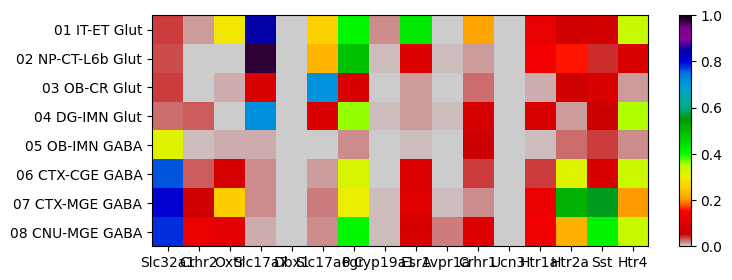

In [ ]:
agg = aggregate_by_metadata(ntexp, gf.gene_symbol, 'class').head(8)
plot_heatmap(agg,8,3,vmax=10)

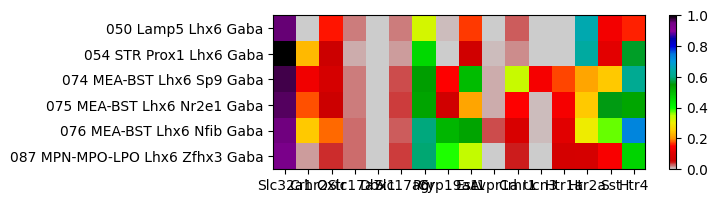

In [ ]:
agg = agg = aggregate_by_metadata(ntexp, gf.gene_symbol, 'subclass')  #No head() means no limit
agg1 = agg
agg1['subclass'] = agg.index
agg_new = agg1['subclass'].str.contains('MEA' and 'Lhx6')  #Can further filter for certain clusters here. I chose a region and a common transcription factor
agg = agg[agg_new]
agg.set_index('subclass', inplace = True)
plot_heatmap(agg, 6,2) #changes the size of the plot

C:\Users\sedwi\AppData\Local\Temp\ipykernel_31728\1068831875.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped = grouped.sort_values(by=gnames[0],ascending=False)


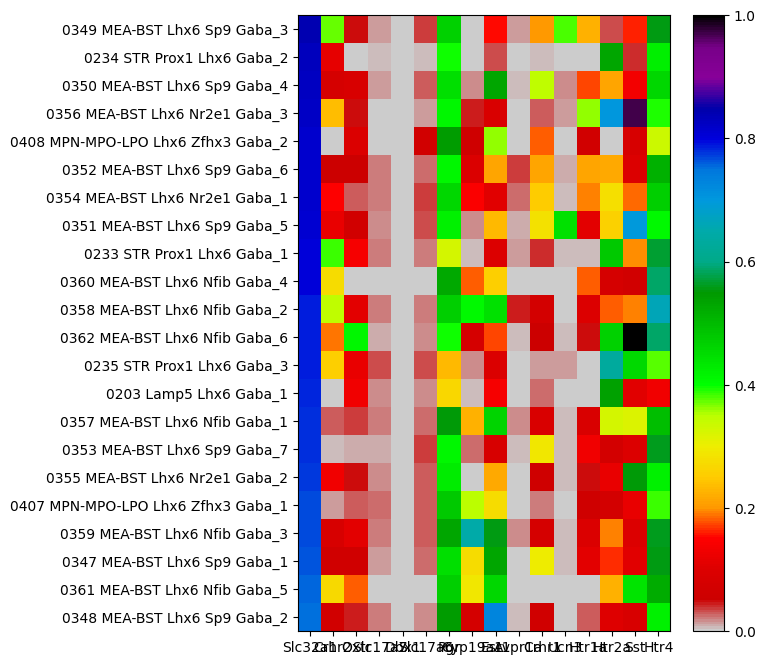

In [ ]:
agg = aggregate_by_metadata(ntexp, gf.gene_symbol, 'supertype',True) #No head() means no limit
agg1 = agg
agg1['supertype'] = agg.index
agg_new = agg1['supertype'].str.contains('MEA' and 'Lhx6') #Can further filter for certain clusters here. I chose a region and a common transcription factor
agg = agg[agg_new]
agg.set_index('supertype', inplace = True)
plot_heatmap(agg, 6, 8) #changes the size of the plot

### Sex Differences

C:\Users\sedwi\AppData\Local\Temp\ipykernel_31728\1068831875.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped = grouped.sort_values(by=gnames[0],ascending=False)


Text(0.5, 1.0, 'Females')

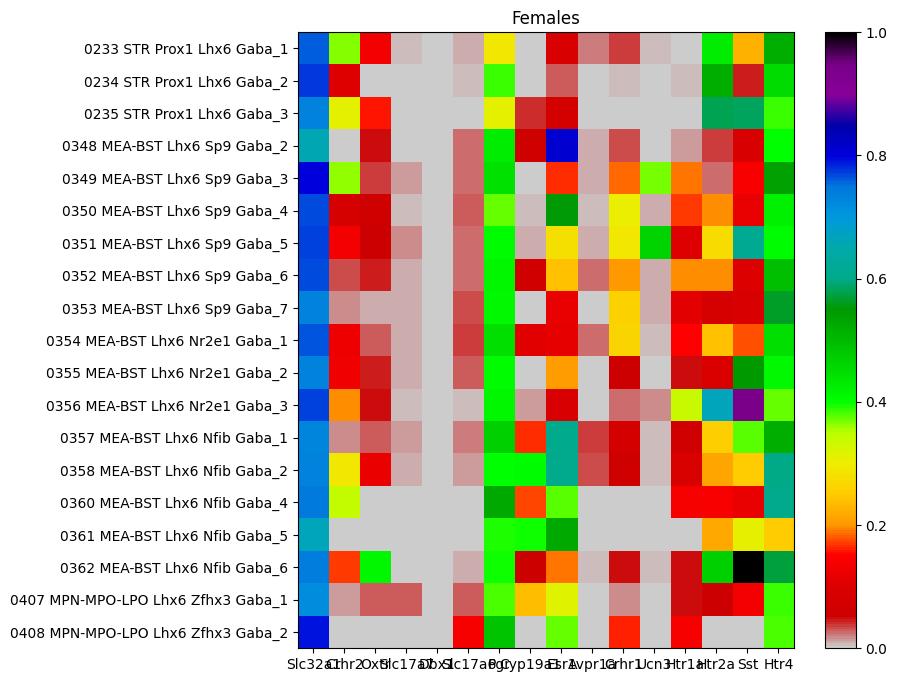

In [ ]:
agg = aggregate_by_metadata(ntexp, gf.gene_symbol, ['donor_sex','supertype'],True) #No head() means no limit
agg1 = agg
# agg1['donor_sex']['supertype'] = agg.index
boolean = []
for i,j in agg.index:
    if '0347' in j or '0359' in j or '0203' in j:
        boolean.append(False)
    elif i=='F' and ('MEA' in j and 'Lhx6' in j or 'Lhx6' in j):
        boolean.append(True)
    else:
        boolean.append(False)
agg = agg[boolean]
agg = agg.sort_index()
# print(agg)
# agg.sort_values([('donor_sex','supertype')])
plot_heatmap_multi(agg, 8, 8) #changes the size of the plot
plt.title('Females')

C:\Users\sedwi\AppData\Local\Temp\ipykernel_31728\1068831875.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped = grouped.sort_values(by=gnames[0],ascending=False)


Text(0.5, 1.0, 'Males')

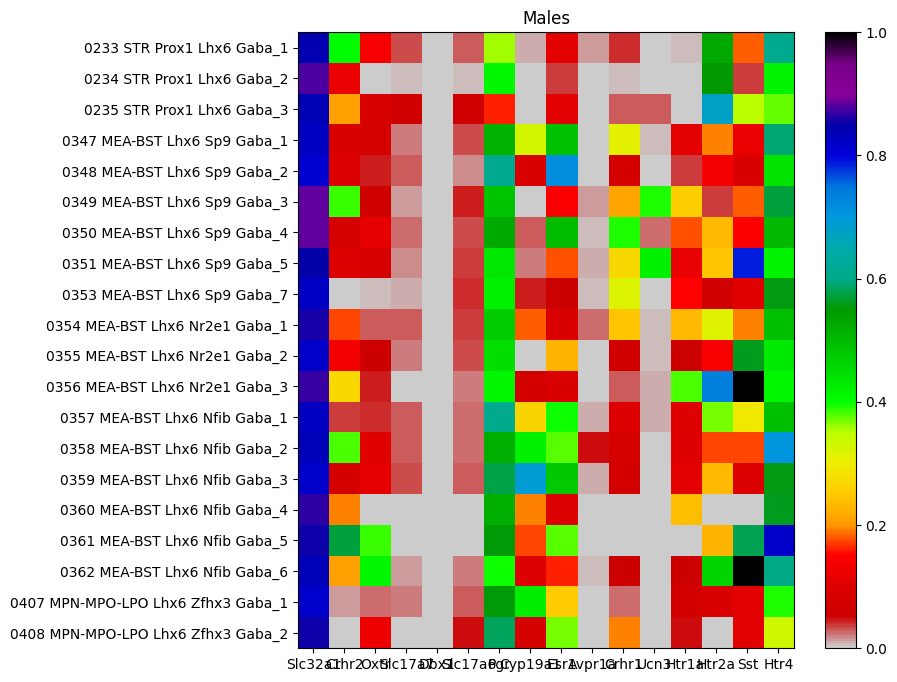

In [ ]:
agg = aggregate_by_metadata(ntexp, gf.gene_symbol, ['donor_sex','supertype'],True) #No head() means no limit
agg1 = agg
# agg1['donor_sex']['supertype'] = agg.index
boolean = []
for i,j in agg.index:
    if '0352' in j or '0203' in j:
        boolean.append(False)
    elif i=='M' and ('MEA' in j and 'Lhx6' in j or 'Lhx6' in j):
        boolean.append(True)
    else:
        boolean.append(False)
agg = agg[boolean]
agg = agg.sort_index()
# agg.set_index('supertype', inplace = True)
plot_heatmap_multi(agg, 8, 8) #changes the size of the plot
plt.title('Males')

### Plot gene expression with respect to each other

In [ ]:
gf = asubset.var[pred]
your_genes = create_expression_dataframe( asubset, gf )

C:\Users\sedwi\AppData\Local\Temp\ipykernel_31728\1068831875.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped = grouped.sort_values(by=gnames[0],ascending=False)


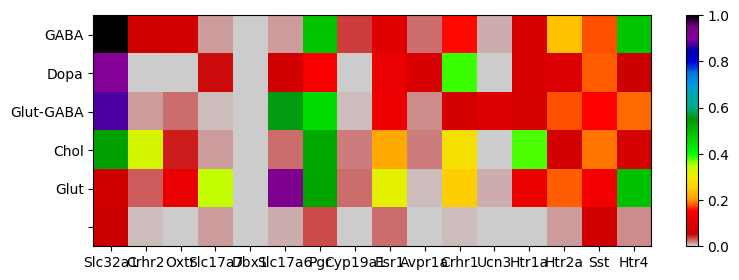

In [ ]:
agg = aggregate_by_metadata(your_genes, gf.gene_symbol, 'neurotransmitter', True).head(10)  #'head()' limits the number of 'y' variables. Remove if you want to see everything
plot_heatmap(agg,9,3)  #The nummbers changes the size of the plot

C:\Users\sedwi\AppData\Local\Temp\ipykernel_31728\1068831875.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped = grouped.sort_values(by=gnames[0],ascending=False)


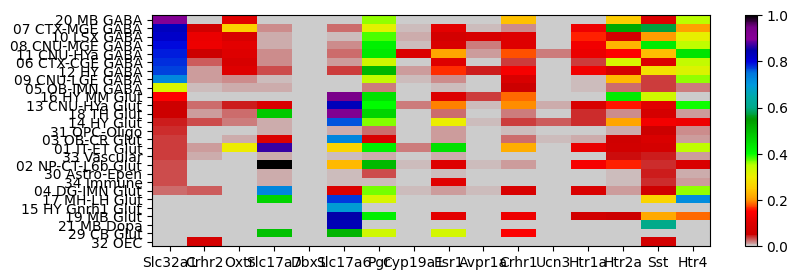

In [ ]:
agg = aggregate_by_metadata(your_genes, gf.gene_symbol, 'class', True) #'head()' limits the number of 'y' variables. Remove if you want to see everything
plot_heatmap(agg,9,3) #The nummbers changes the size of the plot

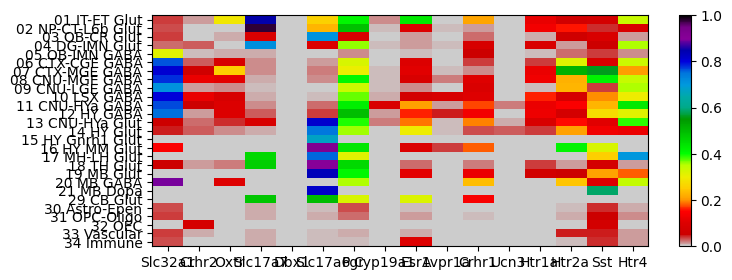

In [ ]:
agg = aggregate_by_metadata(ntexp, gf.gene_symbol, 'class')
plot_heatmap(agg,8,3,vmax=10)

C:\Users\sedwi\AppData\Local\Temp\ipykernel_31728\1068831875.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped = grouped.sort_values(by=gnames[0],ascending=False)


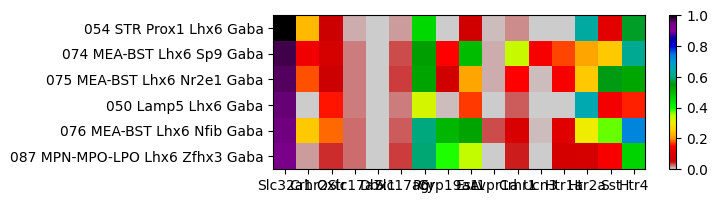

In [ ]:
agg = aggregate_by_metadata(your_genes, gf.gene_symbol, 'subclass',True)  #No head() means no limit
agg1 = agg
agg1['subclass'] = agg.index
agg_new = agg1['subclass'].str.contains('MEA' and 'Lhx6')  #Can further filter for certain clusters here. I chose a region and a common transcription factor
agg = agg[agg_new]
agg.set_index('subclass', inplace = True)
plot_heatmap(agg, 6,2) #changes the size of the plot

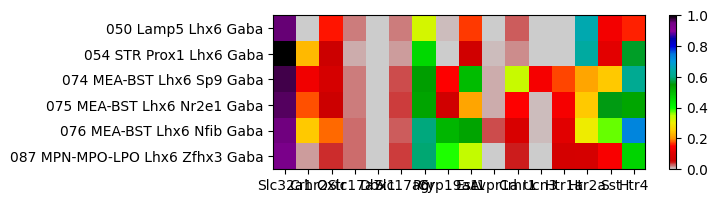

In [ ]:
agg = agg = aggregate_by_metadata(ntexp, gf.gene_symbol, 'subclass')  #No head() means no limit
agg1 = agg
agg1['subclass'] = agg.index
agg_new = agg1['subclass'].str.contains('MEA' and 'Lhx6')  #Can further filter for certain clusters here. I chose a region and a common transcription factor
agg = agg[agg_new]
agg.set_index('subclass', inplace = True)
plot_heatmap(agg, 6,2) #changes the size of the plot